# Imports and configuration

In [195]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from mpl_toolkits.mplot3d import axes3d
from xgboost import XGBClassifier
from datetime import date
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, classification_report, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA, FastICA

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.set_printoptions(precision=2)
np.random.seed(r)
# Remember to call np.random.seed(r) before every function that uses np.random

# Loading original dataset

In [4]:
dataset = pd.read_csv('../common/dataset.csv', header=0, index_col='CUST_COD')
target = pd.read_csv('../common/target.csv', header=0, index_col='CUST_COD')
print(dataset.shape)
print(target.shape)

(26884, 24)
(3116, 24)


In [5]:
dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [6]:
dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


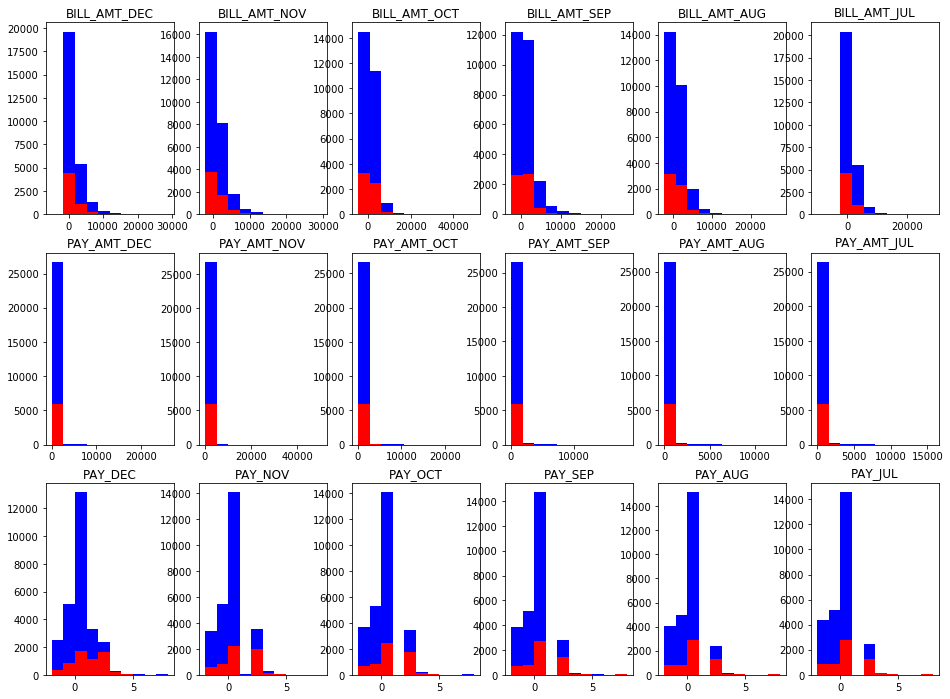

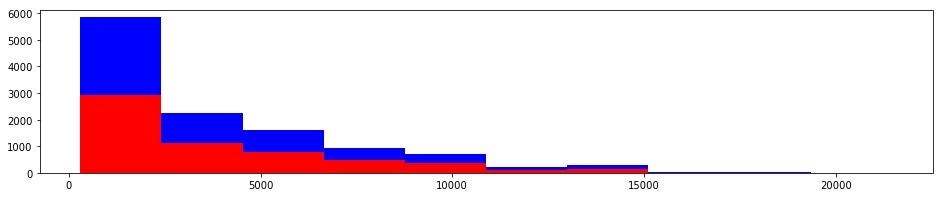

In [8]:
X = dataset

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = X['DEFAULT PAYMENT JAN'] == 1
zeros_mask = X['DEFAULT PAYMENT JAN'] == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
    #ax.legend(loc='best')
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
#plt.legend(loc='best')
plt.show() 

# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [10]:
X_dict = {}
y_dict = {}
X_test_dict = {}
y_test_dict = {}
X_target_dict = {}

names = set()
target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(name, dataset, target):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name]
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name]
    X_target = target.drop(target_col_name, 1)
    add_dataset(name, X, y, X_test, y_test, X_target)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))
    print('Target X shape: {}'.format(X_target.shape))

def add_dataset(name, X, y, X_test, y_test, X_target):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test
    X_target_dict[name] = X_target

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name], X_target_dict[name])

split_and_add('orig', dataset, target)

non_numerical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE']
split_and_add('baseline', dataset.drop(non_numerical_features, 1), target.drop(non_numerical_features, 1))

X, y, X_test, y_test, X_target = retrieve_dataset('baseline')
rs = RobustScaler()
rs.fit(X)
X = pd.DataFrame(rs.transform(X), index = X.index, columns = X.columns)
X_test = pd.DataFrame(rs.transform(X_test), index = X_test.index, columns = X_test.columns)
add_dataset('baseline_scaled', X, y, X_test, y_test, X_target)

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Target X shape: (3116, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)
Target X shape: (3116, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [11]:
def transform_features(X_orig):
    X = X_orig.copy()
    # print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = ['SEX']
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    # print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = {'other': 0, 'high school': 0.25, 'university': 0.75, 'graduate school': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    marriage_dict = {'other': 0, 'single': 0.5, 'married': 1}
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    #print('Computing AGE and dropping BIRTH_DATE')
    # Target: Year-Month-DayTTime
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'])
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())
    min_age = X['AGE'].min()
    max_age = X['AGE'].max()
    X['AGE'] = np.sqrt(X['AGE'].apply(lambda x: (x - min_age) / (max_age - min_age)))
 
    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']

    # print('Normalizing € fields')
    X[fields] = X[fields].apply(lambda x: np.cbrt(x))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative numbe

    # print('Dataset prepared')
    # print(X.shape)
    
    return X.copy()

X, y, X_test, y_test, X_target = retrieve_dataset(name='orig')
X_ale = transform_features(X)
X_test_ale = transform_features(X_test)
X_target = transform_features(X_target)
add_dataset('ale', X_ale, y, X_test_ale, y_test, X_target)
X, y, X_test, y_test, X_target = retrieve_dataset(name='ale')
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.75,0.5,1,2,2,2,2,-2,4.951950,...,0.000000,0.000000,5.119281,0.855483,0.000000,0.000000,0.000000,1,0,0.360041
21308338,8.416822,1.00,0.5,0,0,0,0,0,0,7.777672,...,8.427890,5.302266,3.906743,3.549511,3.100784,2.615302,3.100784,1,0,0.192450
54049646,17.507695,0.25,1.0,0,0,0,0,0,0,14.005143,...,13.631800,4.877483,5.302972,4.546873,5.302266,4.490414,4.569354,1,0,0.720082
10396398,9.634856,0.25,0.5,-1,-1,-2,-2,-2,-2,2.706525,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0.732828
11528589,14.857157,0.75,1.0,0,0,0,0,0,0,11.382419,...,10.220138,4.475580,4.472104,4.472104,4.472104,4.922187,4.472104,0,1,0.593171


In [12]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.745,0.719,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,8.935,...,7.692,4.042,4.000,3.738,3.561,3.532,3.524,0.595,0.396,0.493
std,4.610,0.268,0.260,1.122,1.191,1.195,1.176,1.143,1.158,5.485,...,5.456,2.693,2.769,2.733,2.729,2.706,2.868,0.491,0.489,0.166
min,6.680,0.000,0.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-17.027,...,-21.634,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,11.423,0.750,0.500,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,4.830,...,3.341,3.101,2.913,2.265,2.042,1.956,1.489,0.000,0.000,0.385
50%,16.101,0.750,0.500,0.000,0.000,0.000,0.000,0.000,0.000,8.856,...,8.017,3.971,3.916,3.791,3.550,3.550,3.550,1.000,0.000,0.491
75%,19.270,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,12.646,...,11.391,5.304,5.302,5.119,4.925,4.930,4.922,1.000,1.000,0.609
max,28.172,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,28.133,...,25.057,24.693,33.197,24.745,23.443,23.184,25.073,1.000,1.000,1.000


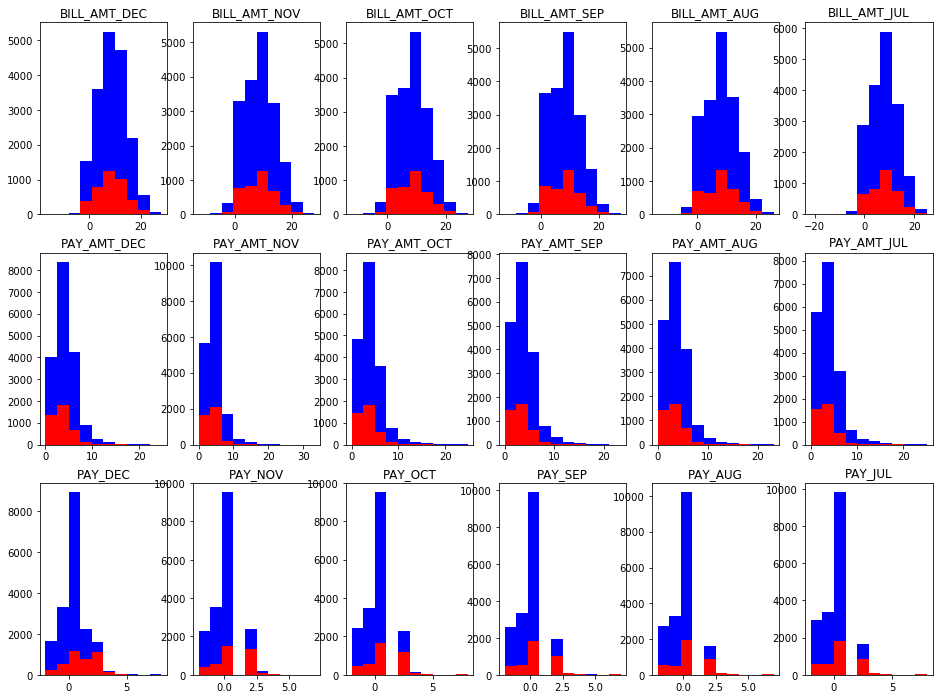

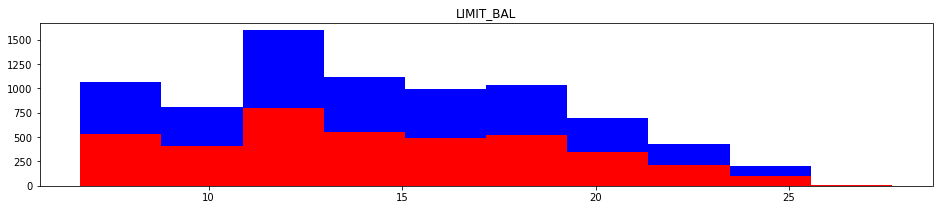

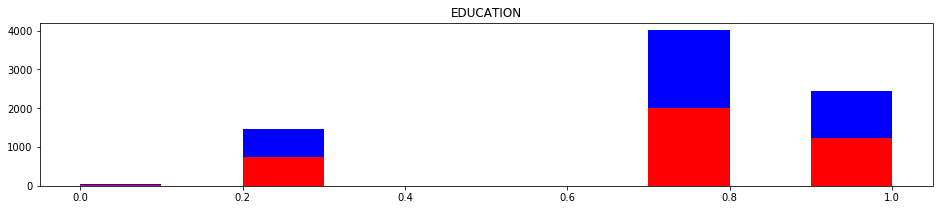

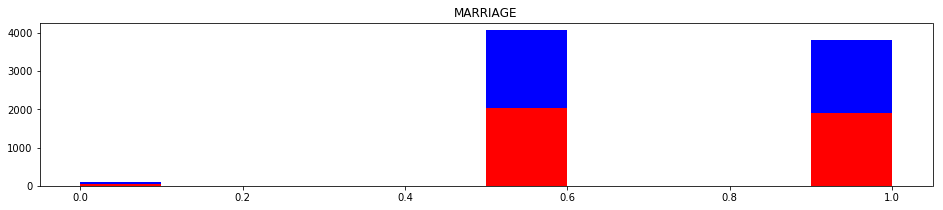

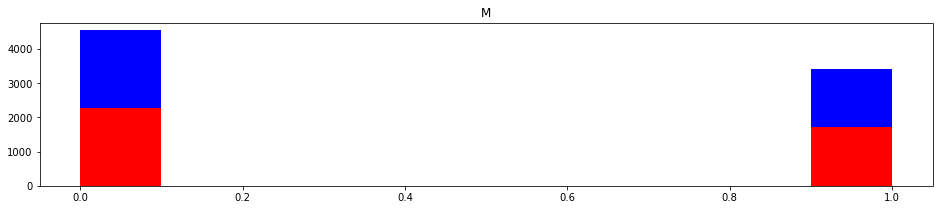

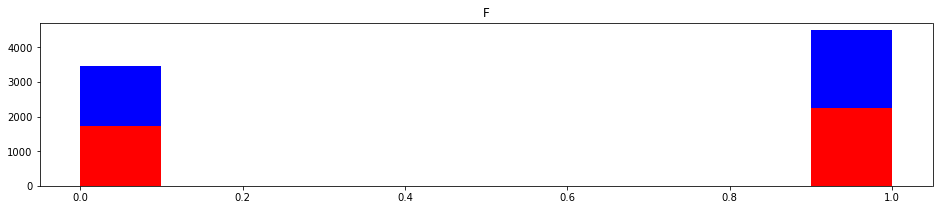

In [21]:
X, y, X_test, y_test, _ = retrieve_dataset(name='ale')

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = y == 1
zeros_mask = y == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.title('LIMIT_BAL')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['EDUCATION'][ones_mask]
zeros = X['EDUCATION'][ones_mask]
plt.title('EDUCATION')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['MARRIAGE'][ones_mask]
zeros = X['MARRIAGE'][ones_mask]
plt.title('MARRIAGE')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['M'][ones_mask]
zeros = X['M'][ones_mask]
plt.title('M')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['F'][ones_mask]
zeros = X['F'][ones_mask]
plt.title('F')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

# Dataset Creation - ale_scaled

In [22]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale')
rs = RobustScaler()
rs.fit(X)
X_scaled = pd.DataFrame(rs.transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns, index=X_test.index)
X_target_scaled = pd.DataFrame(rs.transform(X_target), columns=X_target.columns, index=X_target.index)
add_dataset('ale_scaled', X_scaled, y, X_test_scaled, y_test, X_target_scaled)
X_scaled.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-0.995851,-1.802536,0.503453,-1.028644,-1.231275,-1.193516,-1.033907,0.0,0.0,-0.583923
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,0.051072,0.604417,-0.004078,-0.084631,-0.155657,-0.314126,-0.130706,0.0,0.0,-1.333167
54049646,0.179306,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.697508,0.411587,0.580341,0.264854,0.608005,0.316377,0.297061,0.0,0.0,1.025700
10396398,-0.824073,-2.0,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-0.995851,-1.802536,-1.639320,-1.328413,-1.231275,-1.193516,-1.033907,0.0,0.0,1.082682
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,0.273707,0.229144,0.232565,0.238655,0.320034,0.461559,0.268734,-1.0,1.0,0.458322


In [24]:
if False:
    X, y, X_test, y_test, _ = retrieve_dataset('ale_scaled')
    pd.concat([X, y], axis=1).to_csv('train.csv', index=False)
    pd.concat([X_test, y_test], axis=1).to_csv('test.csv', index=False)

In [25]:
X_scaled.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.034,-0.022,0.438,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,0.010,...,-0.040,0.032,0.035,-0.018,0.004,-0.006,-0.007,-0.405,0.396,0.012
std,0.588,1.072,0.521,1.122,1.191,1.195,1.176,1.143,1.158,0.702,...,0.678,1.223,1.159,0.958,0.947,0.910,0.835,0.491,0.489,0.744
min,-1.201,-3.000,-1.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-3.312,...,-3.683,-1.803,-1.639,-1.328,-1.231,-1.194,-1.034,-1.000,0.000,-2.194
25%,-0.596,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.515,...,-0.581,-0.395,-0.420,-0.535,-0.523,-0.536,-0.600,-1.000,0.000,-0.473
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,...,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.404,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.485,...,0.419,0.605,0.580,0.465,0.477,0.464,0.400,0.000,1.000,0.527
max,1.539,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,2.466,...,2.117,9.407,12.256,7.343,6.901,6.602,6.269,0.000,1.000,2.277


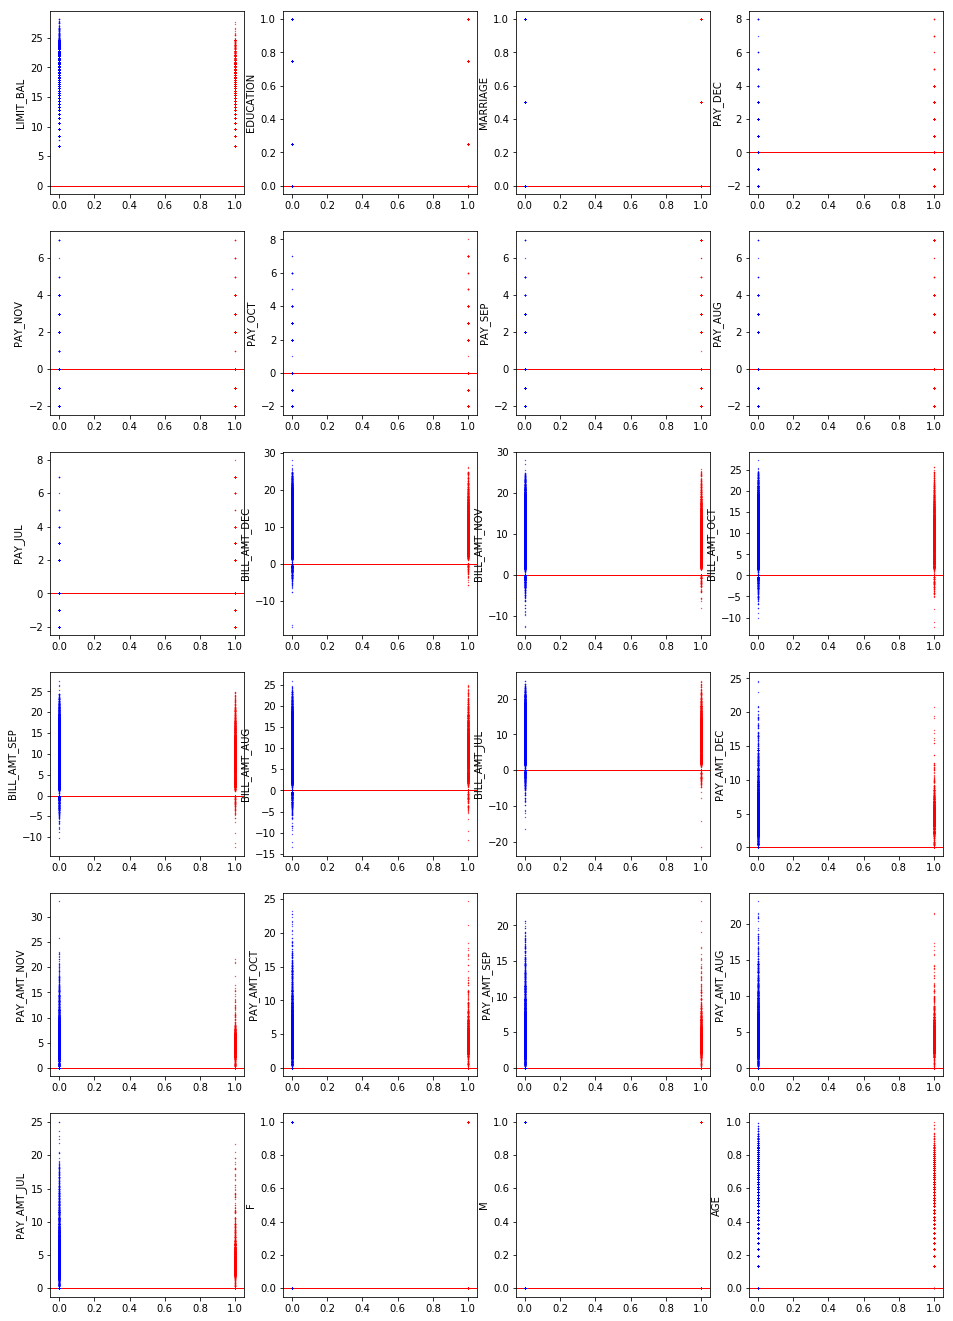

In [26]:
X, y, X_test, y_test, _ = retrieve_dataset('ale')
i = 1
fig = plt.figure(figsize=(16, 12 * 4))
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_ylabel(col_name)
    ax.scatter(y[y==1], X[col_name][y == 1], c='r', s=0.1)
    ax.scatter(y[y==0], X[col_name][y == 0], c='b', s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show()

# Plot confusion matrix function

In [55]:
classes = ['0', '1']

def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Preliminary Prediction Tests

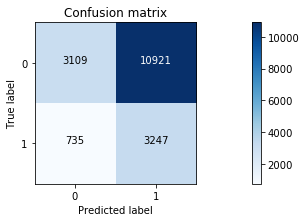

             precision    recall  f1-score   support

          0       0.81      0.22      0.35     14030
          1       0.23      0.82      0.36      3982

avg / total       0.68      0.35      0.35     18012



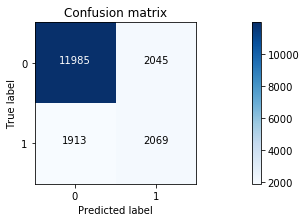

             precision    recall  f1-score   support

          0       0.86      0.85      0.86     14030
          1       0.50      0.52      0.51      3982

avg / total       0.78      0.78      0.78     18012



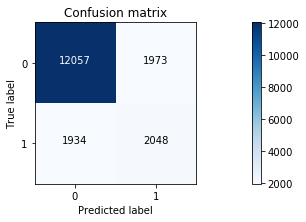

             precision    recall  f1-score   support

          0       0.86      0.86      0.86     14030
          1       0.51      0.51      0.51      3982

avg / total       0.78      0.78      0.78     18012



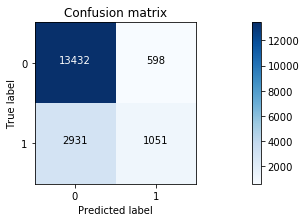

             precision    recall  f1-score   support

          0       0.82      0.96      0.88     14030
          1       0.64      0.26      0.37      3982

avg / total       0.78      0.80      0.77     18012



In [57]:
X, y, X_test, y_test, _ = retrieve_dataset(name='orig')

y_pred = X['PAY_AMT_DEC'] < X['BILL_AMT_DEC']
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'] + 1000)
y_pred &= (X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'] + 1000)
y_pred &= (X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'] + 1000)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_NOV'] > 0)
y_pred &= (X['PAY_OCT'] > 0)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

# PAY_AMT vs Month, BILL_AMT vs Month

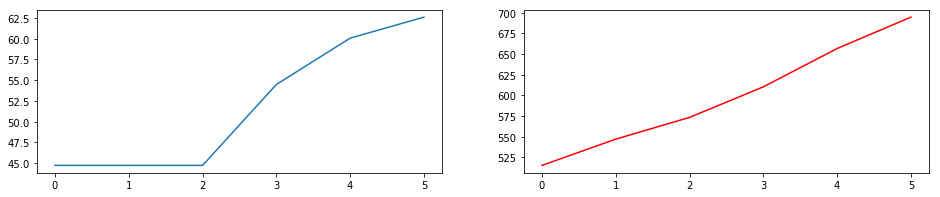

In [58]:
X, y, X_test, y_test, _ = retrieve_dataset(name='orig')
months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

m = [X['PAY_AMT_{}'.format(month)].median() for month in months]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(m)
m = [X['BILL_AMT_{}'.format(month)].median() for month in months]
ax = fig.add_subplot(1, 2, 2)
ax.plot(m, c='r')

plt.show()

# 2D PCA - ale_scaled

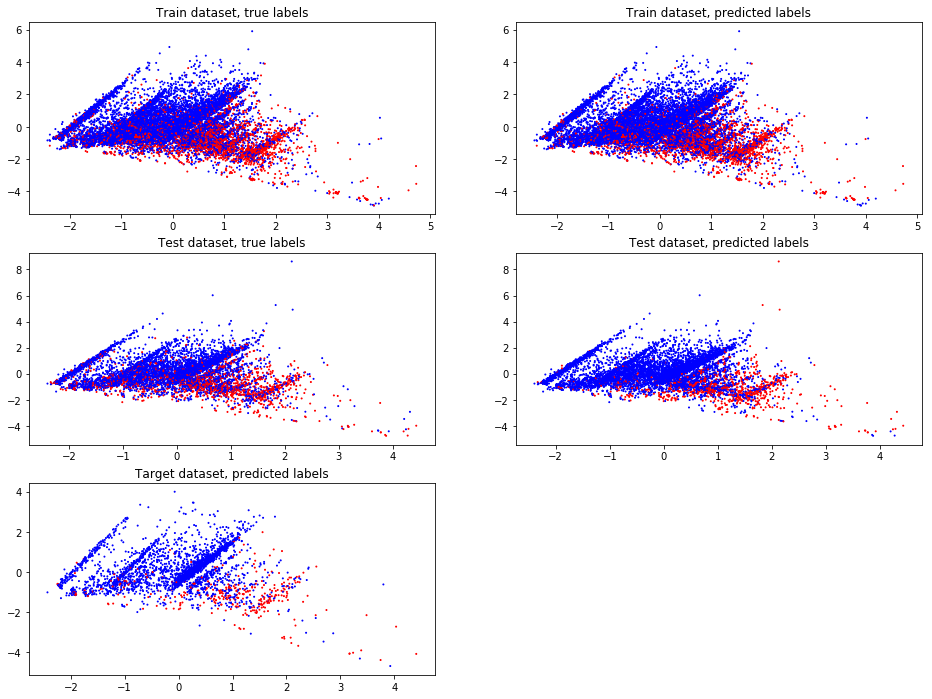

In [68]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r'}
sizes = {0: 1, 1: 1}

def color(y):
    return pd.Series(y).apply(lambda x: colors[x])
def size(y):
    return pd.Series(y).apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=2)
pca.fit(X)

X_tf = pd.DataFrame(pca.transform(X), index=X.index)

clf = RandomForestClassifier()
clf.fit(X_tf, y)

y_pred = clf.predict(X_tf)

X_test_tf = pd.DataFrame(pca.transform(X_test), index=X_test.index)
y_test_pred = clf.predict(X_test_tf)

X_target_tf = pd.DataFrame(pca.transform(X_target), index=X_target.index)
y_target_pred = clf.predict(X_target_tf)

fig = plt.figure(figsize=(16, 3 * 4))

ax = fig.add_subplot(3, 2, 1)
ax.set_title('Train dataset, true labels')
ax.scatter(X_tf[0], X_tf[1], c=color(y), s=size(y))

ax = fig.add_subplot(3, 2, 2)
ax.set_title('Train dataset, predicted labels')
ax.scatter(X_tf[0], X_tf[1], c=color(y_pred), s=size(y_pred))

ax = fig.add_subplot(3, 2, 3)
ax.set_title('Test dataset, true labels')
ax.scatter(X_test_tf[0], X_test_tf[1], c=color(y_test), s=size(y_test))

ax = fig.add_subplot(3, 2, 4)
ax.set_title('Test dataset, predicted labels')
ax.scatter(X_test_tf[0], X_test_tf[1], c=color(y_test_pred), s=size(y_test_pred))

# No true labels on target dataset

ax = fig.add_subplot(3, 2, 5)
ax.set_title('Target dataset, predicted labels')
ax.scatter(X_target_tf[0], X_target_tf[1], c=color(y_target_pred), s=size(y_target_pred))

plt.show()

# 3D PCA - ale_scaled

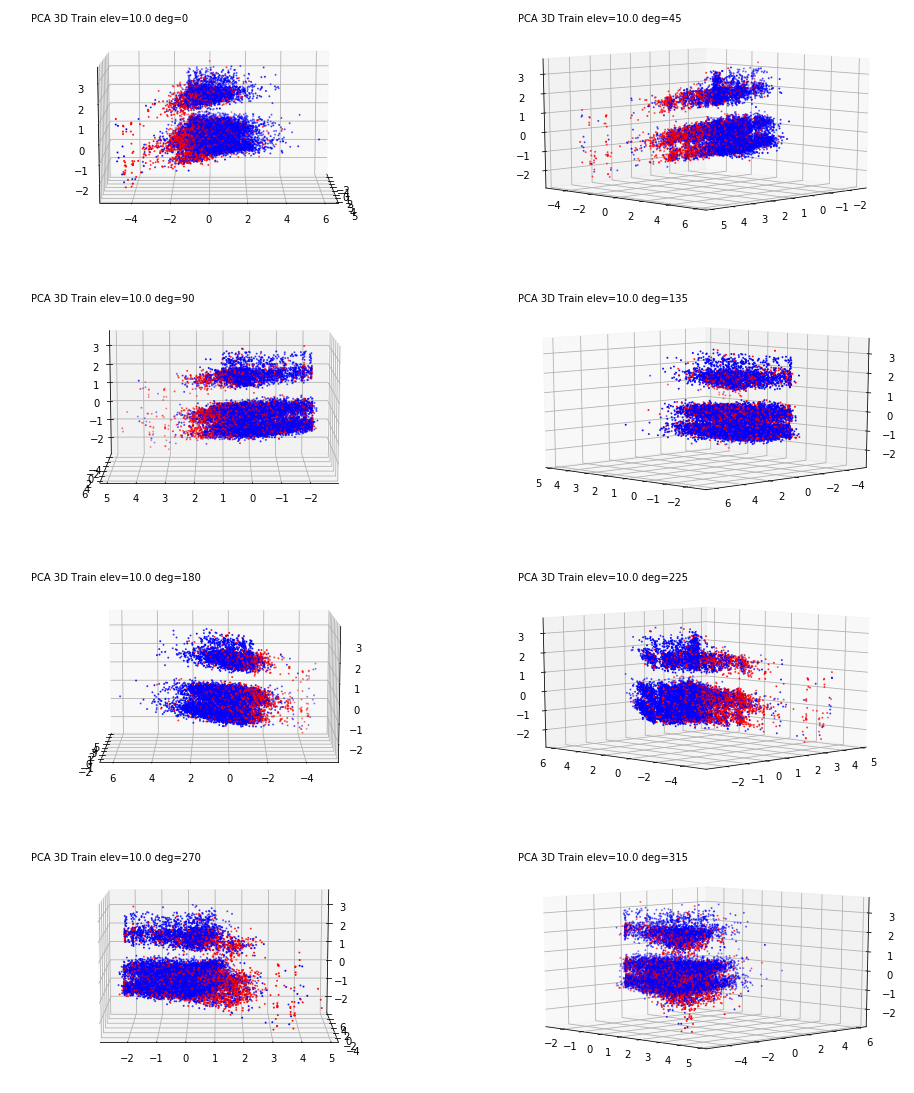

In [69]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 1, 1: 1}
c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=3)
pca.fit(X)
df = pd.DataFrame(pca.transform(X), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

# PCA - tresh = 0.95

Starting PCA
cumsum_tresh = 0.8, n_components = 7
cumsum_tresh = 0.85, n_components = 9
cumsum_tresh = 0.9, n_components = 11
cumsum_tresh = 0.95, n_components = 13
cumsum_tresh = 0.97, n_components = 15
cumsum_tresh = 0.99, n_components = 18


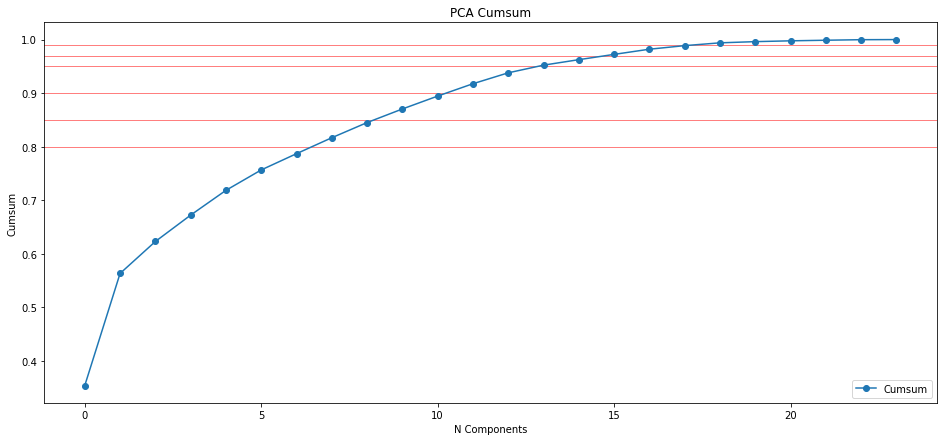

Selecting tresh = 0.95 -> n_components = 13


In [70]:
X, y, X_test, y_test, _ = retrieve_dataset('ale_scaled')

print('Starting PCA')
pca = PCA(whiten=False, random_state=r)
pca.fit(X)

cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))

def find_cumsum_tresh(cumsum, cumsum_tresh):
    for i in np.arange(0, len(cumsum)):
        if cumsum[i] >= cumsum_tresh:
            break
    return i

plt.figure(figsize=(16, 7))
plt.plot(cumsum, label='Cumsum', marker='o')
plt.xlabel('N Components')
plt.ylabel('Cumsum')
plt.title('PCA Cumsum')
plt.legend(loc='best')

for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    n_components = find_cumsum_tresh(cumsum, i)
    print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
    plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

plt.show()

tresh = 0.95

n_components = find_cumsum_tresh(cumsum, tresh)
print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
pca = PCA(whiten=False, random_state=r, n_components=n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), index=X.index)
X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

add_dataset('ale_pca', X_pca, y, X_pca_test, y_test, X_target)

In [71]:
X, y, X_test, y_test, _ = retrieve_dataset('ale_pca')
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
CUST_COD,,,,,,,,,,,,,
14356766,1.439875,-4.098336,-0.410751,0.066664,-0.376472,2.417561,0.142340,0.063112,1.604862,-0.313181,0.750569,-1.219497,-0.503596
21308338,0.389565,-0.264254,-1.313566,0.698834,0.339285,0.251387,-1.105785,0.714457,0.135062,-0.018720,-0.087111,-0.144489,-0.070492
54049646,1.530619,1.178995,2.231277,-0.356016,-0.260402,-0.256812,0.291085,-0.062362,-0.354660,-0.442588,-0.611055,-0.420370,-0.101487
10396398,-5.146938,-2.109424,2.290780,-0.481679,-0.129370,-0.117267,-0.186422,0.029489,-0.144453,-0.658666,-0.288079,-0.185946,-0.029239
11528589,0.877999,0.554631,0.154726,-0.133588,-0.090674,-0.235897,0.628328,-0.426580,-0.098534,0.002533,0.323540,0.565208,0.098101


In [72]:
X.describe().round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000
std,2.662,2.047,1.093,0.993,0.963,0.873,0.780,0.772,0.753,0.713,0.694,0.680,0.639
min,-6.485,-9.973,-2.723,-4.996,-5.607,-5.332,-3.251,-3.768,-3.967,-3.079,-3.027,-3.071,-3.706
25%,-1.818,-1.292,-0.834,-0.495,-0.420,-0.378,-0.517,-0.458,-0.414,-0.507,-0.473,-0.468,-0.302
50%,0.516,-0.125,-0.180,0.010,-0.020,-0.018,-0.008,-0.011,-0.047,-0.128,-0.026,-0.067,-0.005
75%,1.677,1.224,0.268,0.478,0.363,0.369,0.497,0.454,0.384,0.438,0.441,0.528,0.275
max,12.592,12.093,3.676,5.644,5.974,7.045,3.673,4.388,5.659,4.287,3.519,3.078,5.322


# CV and scoring functions

In [84]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')
skf = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)
i = 0
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
#clf = MLPClassifier(hidden_layer_sizes=(9,7), validation_fraction=0.1, random_state=r)
#clf = XGBClassifier(seed=r)
clf = RandomForestClassifier(random_state=r, max_depth=3, n_jobs=-1, n_estimators=300, max_features=4)
# clf = LogisticRegression(penalty='l2', C=10, fit_intercept=True, random_state=r, n_jobs=-1)
# clf = ExtraTreesClassifier(n_estimators=100)
f1s = []
np.random.seed(r)
def fold_transform(y, train):
    y_train_fold = y[train]
    n = y_train_fold.count()
    n_ones = y_train_fold.sum()
    n_zeros = n - n_ones
    train_ones = train[y_train_fold == 1]
    train_zeros = train[y_train_fold == 0]
    train_zeros = np.setdiff1d(train_zeros, np.random.choice(train_zeros, n_zeros - n_ones, replace=False))
    return np.append(train_ones, train_zeros)

for train, test in skf.split(X, y):
    train = fold_transform(y, train)
    clf.fit(X.iloc[train], y.iloc[train])
    y_pred = clf.predict(X.iloc[test])
    f1 = f1_score(y[test], y_pred)
    f1s.append(f1)
    print('fold {}, f1 {}, accuracy {}'.format(i, f1, accuracy_score(y[test], y_pred)))
    i += 1

print('f1 {} +- {}'.format(np.mean(f1s), np.std(f1s)))


fold 0, f1 0.567342073897497, accuracy 0.7985571587125416
fold 1, f1 0.5063879210220673, accuracy 0.7641509433962265
fold 2, f1 0.540045766590389, accuracy 0.7767906718489728
fold 3, f1 0.5399325084364455, accuracy 0.7729039422543031
fold 4, f1 0.5462962962962962, accuracy 0.7823431426985008
fold 5, f1 0.5349112426035503, accuracy 0.781787895613548
fold 6, f1 0.5490654205607477, accuracy 0.7856746252082176
fold 7, f1 0.5763097949886105, accuracy 0.7934480843975569
fold 8, f1 0.5290628706998813, accuracy 0.7795669072737368
fold 9, f1 0.48868778280542985, accuracy 0.7490283176013326
f1 0.5378041677900914 +- 0.024592350454328837


In [202]:
def cv_clf(clf, X, y, y_pred):
    f1s = []
    accs = []
    precs = []
    recs = []
    # i = 0
    for train, test in cv.split(X, y):
        clf.fit(X.iloc[train], y.iloc[train])
        y_pred = clf.predict(X.iloc[test])
        y_true = y.iloc[test]
        f1s.append(f1_score(y_true, y_pred))
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred))
        recs.append(recall_score(y_true, y_pred))
        # print('fold {}, f1 {}, accuracy {}'.format(i, f1, accuracy_score(y[test], y_pred)))
        # i += 1
    print('f1_cv = {:.3f} ± {:.3f}'.format(np.mean(f1s), np.std(f1s)))
    print('acc_cv = {:.3f} ± {:.3f}'.format(np.mean(accs), np.std(accs)))
    print('prec_cv = {:.3f} ± {:.3f}'.format(np.mean(precs), np.std(precs)))
    print('rec_cv = {:.3f} ± {:.3f}'.format(np.mean(recs), np.std(recs)))
    #cm_train = confusion_matrix(y, y_pred)
    #print('CONFUSION MATRIX TRAIN')
    #plot_confusion_matrix(cm_train)

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test, X_target = retrieve_dataset(name)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    y_pred_target = clf.predict(X_target)
    cv_clf(clf, X, y, y_pred)
    return (y_pred, y_pred_test, y_pred_target)

cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)    
ms = make_scorer(score_matrix, greater_is_better=True)

# ROC curve function

In [203]:
def plot_roc_curve(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    t_sigm = 1 / (1 + np.exp(-t))

    i = sum(t < 0.5 for t in t_sigm)
    
    plt.figure(figsize=(16,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [204]:
def grid_search_cv(parameters, clf, n_folds=10, dataset_name='baseline', scoring='f1'):
    cv=StratifiedKFold(n_splits=n_folds, random_state=r, shuffle=True)
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test, _ = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    if scoring == ms:
            scoring = 'score'
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Level 1 algorithms - Learning from features

In [255]:
X, y, X_test, y_test, X_target = retrieve_dataset('orig')
X_meta = pd.DataFrame(index=X.index)
X_meta_test = pd.DataFrame(index=X_test.index)
X_meta_target = pd.DataFrame(index=X_target.index)

def fit_score_add_meta(clf, alg_name, dataset_name):
    name = alg_name + '_' + dataset_name
    X_meta[name], X_meta_test[name], X_meta_target[name] = fit_and_score(clf, dataset_name)

# Level 1 - Dummy Classifier
- All datasets: f1_cv = 0.217 ± 0.018

In [256]:
clf = DummyClassifier(random_state=r)
_, _, _ = fit_and_score(clf, 'baseline')

Evaluating on baseline dataset
f1_cv = 0.217 ± 0.018
acc_cv = 0.650 ± 0.008
prec_cv = 0.214 ± 0.018
rec_cv = 0.219 ± 0.018


# Level 1 - Linear Support Vector Classifier
- baseline: f1_cv = 0.522 ± 0.023

In [257]:
clf = LinearSVC(penalty='l2',
                loss='squared_hinge',
                dual=False,
                tol=1e-4,
                C=0.01,
                fit_intercept=True,
                intercept_scaling=1.0,
                class_weight='balanced',
                verbose=0,
                random_state=r,
                max_iter=1000
               )
fit_score_add_meta(clf, 'LinearSVC', 'ale_scaled')

Evaluating on ale_scaled dataset
f1_cv = 0.503 ± 0.021
acc_cv = 0.725 ± 0.013
prec_cv = 0.419 ± 0.019
rec_cv = 0.629 ± 0.025


# Level 1 - TOO SLOW, OVERFITS Level 2 - Support Vector Classifier
- ale_pca: f1_cv = 0.351 ± 0.026

In [258]:
if False:
    clf = SVC(random_state=r, C=1, class_weight='balanced')
    fit_score_add_meta(clf, 'SVC', 'ale_pca')

# Level 1 - Decision Tree Classifier
- baseline: f1_cv = 0.533 ± 0.021

In [259]:
clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
fit_score_add_meta(clf, 'DecisionTreeClassifier', 'ale')

Evaluating on ale dataset
f1_cv = 0.533 ± 0.021
acc_cv = 0.778 ± 0.011
prec_cv = 0.498 ± 0.020
rec_cv = 0.573 ± 0.027


# Level 1 - Gaussian Naive Bayes
- baseline: f1_cv = 0.521 ± 0.014

In [260]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
fit_score_add_meta(clf, 'GaussianNB', 'baseline')

Evaluating on baseline dataset
f1_cv = 0.521 ± 0.014
acc_cv = 0.766 ± 0.009
prec_cv = 0.476 ± 0.016
rec_cv = 0.577 ± 0.023


# Level 1 - Random Forest Classifier
- baseline: f1_cv = 0.533 ± 0.026
- ale: f1_cv = 0.539 ± 0.025

In [261]:
clf = RandomForestClassifier(random_state=r, max_depth=3, n_jobs=-1, class_weight='balanced', n_estimators=300, max_features=4)
fit_score_add_meta(clf, 'RandomForestClassifier', 'ale_scaled')

Evaluating on ale_scaled dataset
f1_cv = 0.539 ± 0.025
acc_cv = 0.780 ± 0.013
prec_cv = 0.503 ± 0.025
rec_cv = 0.581 ± 0.029


Feature ranking:
1. feature PAY_DEC (0.295793)
2. feature PAY_NOV (0.165495)
3. feature PAY_OCT (0.122207)
4. feature PAY_SEP (0.101293)
5. feature PAY_AUG (0.077063)
6. feature PAY_JUL (0.059834)
7. feature PAY_AMT_DEC (0.047152)
8. feature LIMIT_BAL (0.032197)
9. feature PAY_AMT_NOV (0.020991)
10. feature PAY_AMT_OCT (0.019197)
11. feature PAY_AMT_SEP (0.014693)
12. feature PAY_AMT_JUL (0.011025)
13. feature PAY_AMT_AUG (0.008572)
14. feature BILL_AMT_DEC (0.006018)
15. feature BILL_AMT_NOV (0.004402)
16. feature BILL_AMT_OCT (0.004085)
17. feature BILL_AMT_AUG (0.003427)
18. feature BILL_AMT_SEP (0.003206)
19. feature BILL_AMT_JUL (0.001946)
20. feature EDUCATION (0.000561)
21. feature AGE (0.000424)
22. feature F (0.000182)
23. feature M (0.000171)
24. feature MARRIAGE (0.000065)


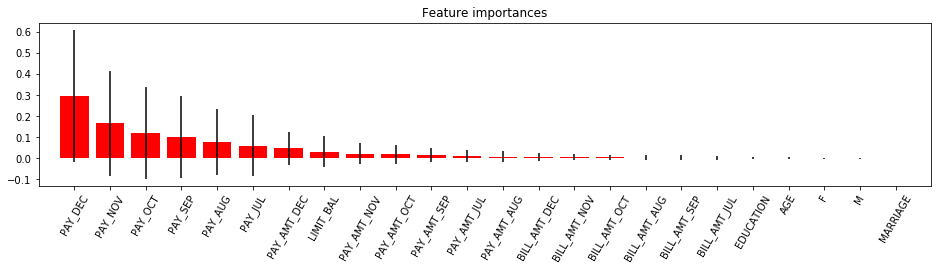

In [262]:
X, y, X_test, y_test, _ = retrieve_dataset('ale_scaled')
forest = clf
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# Level 1 - OVERFITS Level 2 - K Neighbors Classifier
- baseline_scaled: f1_cv = 0.442 ± 0.024

In [296]:
if False:
    clf = KNeighborsClassifier(n_neighbors=20,
                           weights='distance',
                           algorithm='auto',
                           leaf_size=30,
                           p=2,
                           metric='minkowski',
                           metric_params=None,
                           n_jobs=-1
                          )
    fit_score_add_meta(clf, 'KNeighborsClassifier', 'ale_scaled')    

Evaluating on ale_scaled dataset
f1_cv = 0.457 ± 0.025
acc_cv = 0.812 ± 0.008
prec_cv = 0.632 ± 0.031
rec_cv = 0.358 ± 0.023


# Level 1 - Multi Layer Perceptron Classifier
- ale: f1_cv = 0.525 ± 0.025 (24,12,8,4,2)

In [265]:
clf = MLPClassifier(# hidden_layer_sizes=(24,12,8,4,2),
                    hidden_layer_sizes=(16,8),
                    # solver='adam',
                    # activation='logistic',
                    # batch_size=500,
                    validation_fraction=0.1,
                    random_state=r,
                    # verbose=False
                   )
fit_score_add_meta(clf, 'MLPClassifier', 'ale_scaled')

Evaluating on ale_scaled dataset
f1_cv = 0.475 ± 0.028
acc_cv = 0.818 ± 0.007
prec_cv = 0.655 ± 0.024
rec_cv = 0.374 ± 0.029


# Level 1 - Logistic Regression
- ale_pca: f1_cv = 0.511 ± 0.018

In [266]:
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
# grid_search_cv(parameters={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}, clf=clf, scoring='f1', dataset_name='ale_pca')
fit_score_add_meta(clf, 'LogisticRegression', 'ale_scaled')

Evaluating on ale_scaled dataset
f1_cv = 0.501 ± 0.020
acc_cv = 0.720 ± 0.013
prec_cv = 0.414 ± 0.018
rec_cv = 0.635 ± 0.024


[[-0.06  0.05  0.15  0.44  0.11  0.04  0.06  0.09  0.06 -0.33 -0.03  0.25
   0.13 -0.22  0.18 -0.16 -0.22 -0.16 -0.08 -0.11  0.    0.23  0.32  0.1 ]]


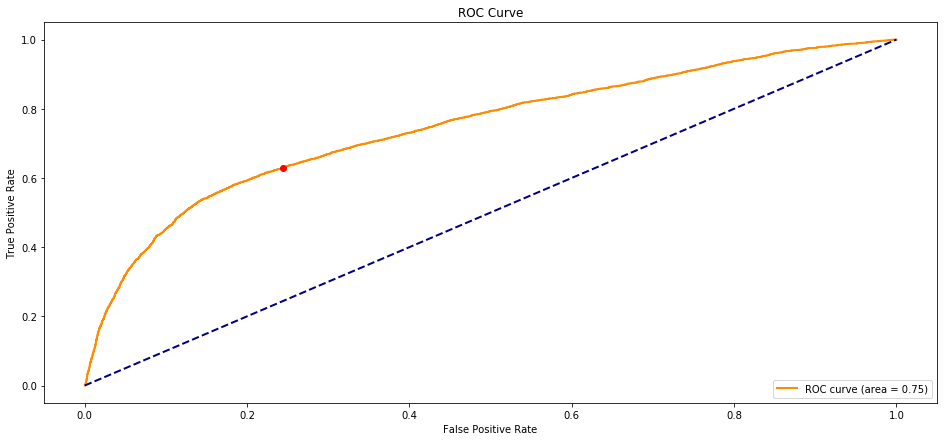

In [267]:
X, y, X_test, y_test, _ = retrieve_dataset('ale_scaled')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, X, y)

# Level 1 - XGBClassifier
- ale: f1_cv = 0.548 ± 0.021

In [268]:
clf = XGBClassifier(seed=r,
                    scale_pos_weight=3,
                    learning_rate=0.1
                   )
fit_score_add_meta(clf, 'XGBClassifier', 'ale')

Evaluating on ale dataset
f1_cv = 0.546 ± 0.021
acc_cv = 0.786 ± 0.011
prec_cv = 0.514 ± 0.021
rec_cv = 0.583 ± 0.024


Feature ranking:
1. feature BILL_AMT_DEC (0.139818)
2. feature PAY_DEC (0.072948)
3. feature LIMIT_BAL (0.069909)
4. feature PAY_AMT_DEC (0.060790)
5. feature PAY_AMT_NOV (0.057751)
6. feature PAY_AMT_JUL (0.057751)
7. feature BILL_AMT_NOV (0.050152)
8. feature BILL_AMT_OCT (0.050152)
9. feature PAY_AMT_OCT (0.048632)
10. feature PAY_AMT_SEP (0.047112)
11. feature EDUCATION (0.036474)
12. feature PAY_AMT_AUG (0.033435)
13. feature BILL_AMT_AUG (0.031915)
14. feature BILL_AMT_SEP (0.031915)
15. feature PAY_JUL (0.031915)
16. feature PAY_NOV (0.030395)
17. feature AGE (0.030395)
18. feature BILL_AMT_JUL (0.027356)
19. feature PAY_OCT (0.027356)
20. feature PAY_SEP (0.021277)
21. feature PAY_AUG (0.016717)
22. feature MARRIAGE (0.013678)
23. feature M (0.010638)
24. feature F (0.001520)


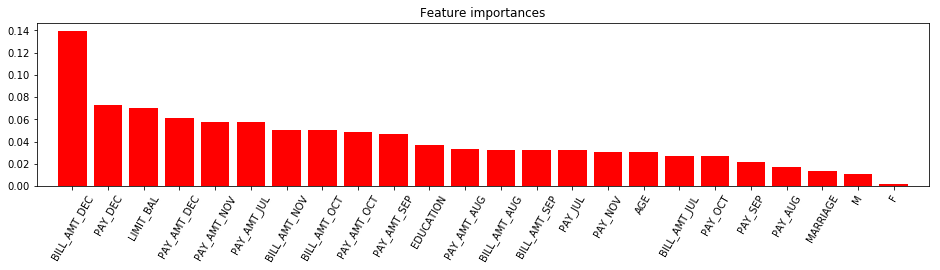

In [269]:
X, y, X_test, y_test, _ = retrieve_dataset('ale')
forest = clf
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# Level 1 - MEMORY ERROR, Gaussian Process Classifier

In [270]:
if False:
    clf = GaussianProcessClassifier(kernel=None,
                                optimizer='fmin_l_bfgs_b',
                                n_restarts_optimizer=0, 
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=r,
                                #multi_class='one_vs_rest',
                                n_jobs=-1)
    fit_score_add_meta(clf, 'GaussianProcessClassifier', 'baseline')

# Level 1 - Linear Discriminant Analysis

In [271]:
clf = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=[0.5, 0.5], 
                                 n_components=None, store_covariance=False, tol=0.0001)
fit_score_add_meta(clf, 'LinearDiscriminantAnalysis', 'ale')

Evaluating on ale dataset
f1_cv = 0.512 ± 0.021
acc_cv = 0.745 ± 0.014
prec_cv = 0.444 ± 0.021
rec_cv = 0.605 ± 0.021


# Level 1 - Quadratic Discriminant Analysis

In [272]:
clf = QuadraticDiscriminantAnalysis(priors=[0.5, 0.5], reg_param=0.1, store_covariances=False, tol=0.0001)
fit_score_add_meta(clf, 'QuadraticDiscriminantAnalysis', 'ale')

Evaluating on ale dataset
f1_cv = 0.520 ± 0.018
acc_cv = 0.747 ± 0.012
prec_cv = 0.449 ± 0.018
rec_cv = 0.619 ± 0.020


# Build meta dataset for Level 2

In [299]:
X, y, X_test, y_test, X_target = retrieve_dataset('orig')
add_dataset('meta', X_meta, y, X_meta_test, y_test, X_meta_target)
X, y, X_test, y_test, X_target = retrieve_dataset('meta')
X_target.head(5)

,LinearSVC_ale_scaled,DecisionTreeClassifier_ale,GaussianNB_baseline,RandomForestClassifier_ale_scaled,MLPClassifier_ale_scaled,LogisticRegression_ale_scaled,XGBClassifier_ale,LinearDiscriminantAnalysis_ale,QuadraticDiscriminantAnalysis_ale,KNeighborsClassifier_ale_scaled
CUST_COD,,,,,,,,,,
70696449,0,0,0,0,0,0,0,0,0,0
76505586,1,1,1,0,0,1,0,1,1,0
88442515,1,0,0,0,0,1,0,1,0,0
73457138,0,0,0,0,0,0,0,0,0,0
68367768,0,0,0,0,0,0,0,0,0,0


# Learning from predictions - Level 2 algorithms

# Level 2 - Logistic Regression
- f1_cv = 0.570 ± 0.020
- f1_test = 0.542

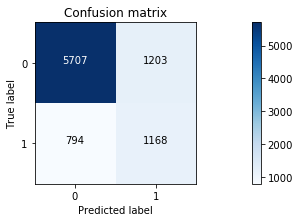

             precision    recall  f1-score   support

          0       0.88      0.83      0.85      6910
          1       0.49      0.60      0.54      1962

avg / total       0.79      0.77      0.78      8872

0.774909828674
[[ 0.19  0.06  0.22  0.02  0.65  0.21  0.76 -0.09  0.38  0.37]]


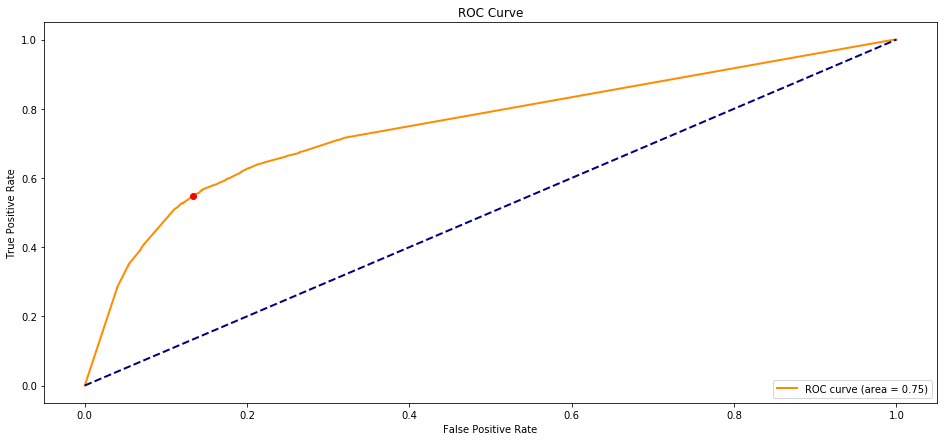

In [300]:
# parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
#grid_search_cv(parameters=parameters, clf=clf, scoring='f1', dataset_name='meta')
_, _, X_test, y_test, _ = retrieve_dataset('meta')
clf.fit(X_test, y_test)

y_pred = clf.predict(X_test)

plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)